# Esercitazione 5

Lo scopo di questa esercitazione è implementare una prima applicazione dell'algoritmo di Metropolis, per campionare il modulo quadro della funzione d'onda $|\Psi(\vec{r},t)|^2$ dell'elettrone in un atomo di idrogeno. Fatto questo, viene richiesto di utilizzare le posizioni campionate per stimare $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ e $\left\langle r \right\rangle_{\Psi_{2,1,0}}$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle(){
 if (code_show){ $('div.input').hide();
 } else { $('div.input').show();}
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

### Esercizio 5.1

In questo esercizio utilizziamo l'algoritmo di Metropolis per campionare delle densità di probabilità in coordinate cartesiane note dalla meccanica quantistica. Successivamente usiamo il campionamento per calcolare $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ e $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ e usando il metodo del datablocking ne stimiamo le incertezze statistiche. Notiamo infatti che $|\Psi(\vec{r},t)|^2$ può essere interpretato come la densità di probabilità che la particella si trovi in un volumetto infinitesimo centrato in $\vec{r}$ al tempo t e perciò vogliamo campionarla.
In coordinate polari sferiche abbiamo che la funzione d'onda di ground-state ($n=1,\,m=0,\,l=0$) si scrive in questo modo:

$$\Psi_{1,0,0}(r,\theta,\phi)=\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0}$$

mentre quella relativa allo stato eccitato $2p$ ($n=0,\,m=1,\,l=0$) è:

$$\Psi_{2,1,0}(r,\theta,\phi)=\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta)$$

dove $a_0=4\pi\epsilon_0\hbar^2/m_ee^2=0.0529 nm$ è il raggio di Bohr e $r$ il modulo del raggio $\vec{r}$. Passando alle coordinate cartesiane otteniamo che la funzione d'onda di ground-state ha la seguente espressione:

$$\Psi_{1,0,0}(x,y,z)=\frac{a_0^{-3}}{\pi} e^{-\frac{2}{a_0}\sqrt{x^2+y^2+z^2}} $$

mentre quella relativa allo stato eccitato $2p$ è descritta dalla seguente formula:

$$\Psi_{2,1,0}(x,y,z)=\frac{a_0^{-5}}{32\pi} z^2 e^{-\frac{1}{a_0}\sqrt{x^2+y^2+z^2}} $$

Si può dimostrare che i valori di aspettazione del raggio elettronico per la prima e la seconda distribuzione valgono rispettivamente: 

$$\left\langle r \right\rangle_{\Psi_{1,0,0}}=\frac{3}{2}a_0\quad\text{e}\quad\left\langle r \right\rangle_{\Psi_{2,1,0}}=5a_0$$

Questi sono i valori teorici con i quali vengono confrontati i risultati numerici delle simulazioni.
Qui di seguito vengono mostrati i grafici 3D dei due orbitali (ottenuti mediante le simulazioni Monte Carlo spiegate in seguito).

In [33]:
M = 10**6
X1 = np.zeros(M)
Y1 = np.zeros(M)
Z1 = np.zeros(M)
X2 = np.zeros(M)
Y2 = np.zeros(M)
Z2 = np.zeros(M)

fileXYZ1 = open('1s_path_uniform.dat', 'r')
fileXYZ2 = open('2p_path_uniform.dat', 'r')

for i in range(M):
    X1[i], Y1[i], Z1[i] = fileXYZ1.readline().split()
    X2[i], Y2[i], Z2[i] = fileXYZ2.readline().split()

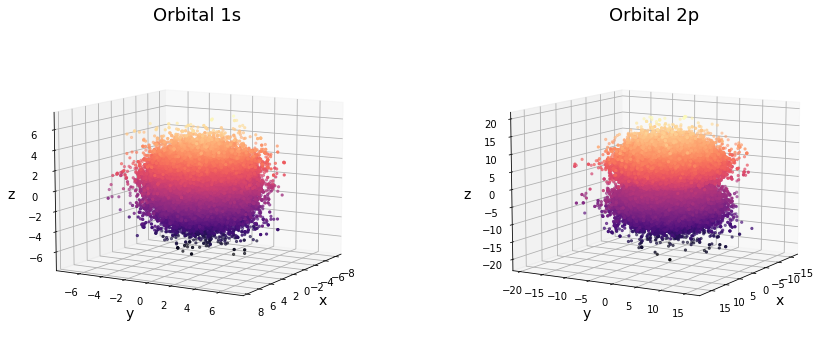

In [35]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('Orbital 1s',fontsize=18)
ax.scatter(X1[1000:M], Y1[1000:M], Z1[1000:M], c=Z1[1000:M], marker='.',cmap='magma')
ax.set_xlabel('x',fontsize=14)
ax.set_ylabel('y',fontsize=14)
ax.set_zlabel('z',fontsize=14)
ax.view_init(10, 30)
ax.grid(True)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title('Orbital 2p',fontsize=18)
ax.scatter(X2, Y2, Z2, c=Z2, marker='.',cmap='magma')
ax.set_xlabel('x',fontsize=14)
ax.set_ylabel('y',fontsize=14)
ax.set_zlabel('z',fontsize=14)
ax.view_init(10, 30)
ax.grid(True)

plt.show()

L'algoritmo di *Metropolis* funziona in questo modo: partendo da un punto scelto $\vec{x}_{init}$, viene proposta una mossa secondo la distribuzione $T(\vec{y}|\vec{x}_{init})$ che può essere accettata o rifiutata con una probabilità detta di accettazione $A(\vec{y}|\vec{x}_{init})$. 
La successione delle mosse accettate genera una catena di Markov che porta l'insieme delle nuove posizioni a campionare la p.d.f. desiderata.

Per i nostri scopi la distribuzione $T(\vec{y}|\vec{x})$ viene scelta prima uniforme e poi gaussiana centrata in $\vec{x}$. Queste due distribuzioni sono entrambe simmetriche nello scambio di $\vec{y}$ e $\vec{x}$ e ciò ci consente di usufruire in entrambi i casi di una forma semplificata per l'espressione della probabilità di accettazione, ossia $A(\vec{y}|\vec{x})=\min\big(1,q(\vec{y}|\vec{x})\big)$ con:

$$ q(\vec{y}|\vec{x}) = \frac{T(\vec{y}|\vec{x})p(\vec{y})}{T(\vec{x}|\vec{y})p(\vec{x})}=\frac{p(\vec{y})}{p(\vec{x})}$$

dove $p(\vec{x})$ rappresenta la p.d.f. che si intende campionare.

Ci chiediamo ora da quale punto $\vec{x}_{init}$ è conveniente far partire la simulazione. Se infatti il punto iniziale è un punto lontano dall'origine (ad esempio $\vec{x}_{init}=(100,100,100)$ in unità di $a_0$), si può notare dal grafico sottostante come  la densità di probabilità campionata dall'algoritmo di Metropolis sia quella tipica di un orbitale solo dopo un certo numero di passi necessari all'equilibrazione. Nello specifico, il valore del raggio impiega circa 30-40 blocchi a stabilizzarsi nelle vicinanze del valore atteso.

In [17]:
N = 10**6
M = 10**3
L = 10**3
X = np.zeros(N)
Y = np.zeros(N)
Z = np.zeros(N)
r = np.zeros(L)
fileXYZ = open('1s_path_uniform.dat', 'r')
x_blocks = np.arange(2,101,1)
data_eq = np.loadtxt('1s_equilibration_uniform.dat')

for i in range(N):
    X[i], Y[i], Z[i] = fileXYZ.readline().split()
for j in range(L):
    _sum=0
    for i in range(j*M,(j+1)*M,1):
         _sum += np.sqrt(X[i]*X[i] + Y[i]*Y[i] + Z[i]*Z[i])
    r[j] = _sum/M

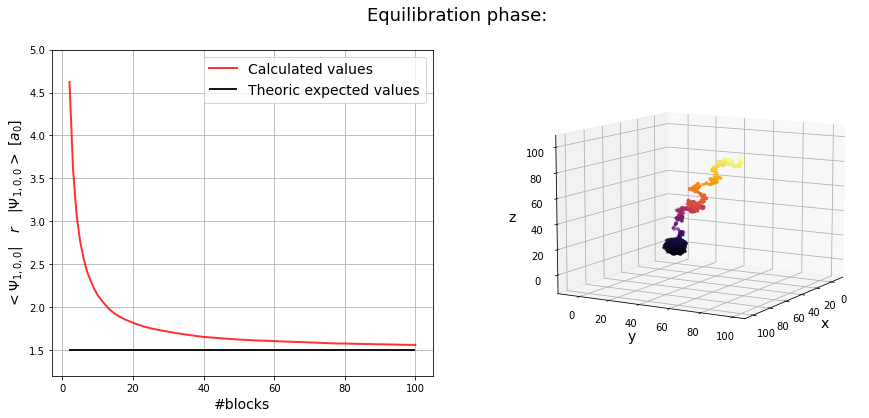

In [43]:
fig = plt.figure(figsize=(15,6))
fig.suptitle("Equilibration phase:",fontsize=18)
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_blocks, data_eq.T[0], color='r', alpha=0.8, label='Calculated values', linewidth=2)
ax.hlines(1.5,2,100, color='black', linestyle='-', label="Theoric expected values", linewidth=2, alpha=0.9)
ax.set_ylabel(r'$<\Psi_{1,0,0}|\quad r \quad|\Psi_{1,0,0}> \,\, [a_0]$',fontsize=14)
ax.set_xlabel("#blocks",fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
ax.set_ylim(1.2,5)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(X, Y, Z, c=Z, marker='.',cmap='inferno')
ax.set_xlabel('x',fontsize=14)
ax.set_ylabel('y',fontsize=14)
ax.set_zlabel('z',fontsize=14)
ax.view_init(10, 30)
ax.grid(True)
plt.show()

Per simulare $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ partiamo da $\vec{r}_0=(1,1,1)$ in unità di raggio di Bohr $a_0$, che sembra essere una posizione iniziale ragionevole senza la necessità di una fase di equilibrazione preliminare. Ripetendo il ragionamento, per simulare $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ si sceglie di partire dalla posizione $\vec{r}_0=(2,2,3)$ in unità di raggio di Bohr.

A questo punto dobbiamo scegliere la lunghezza del passo caratterizzante la probabilità di transizione $T(\vec{x}|\vec{y})$ in modo tale da rispettare la regola empirica del $50\%$. Il *Metropolis* infatti funziona in maniera ottimale quando la mossa proposta può essere accettata con una probabilità del $50\%$.
Il valore del passo cambia a seconda del tipo di probabilità di transizione e dalla probabilità $p(x)$ da campionare, perciò viene precisato successivamente di simulazione in simulazione.

Per tutte le simulazioni viene utilizzato il metodo del data-blocking per stimare le incertezze per un numero di misure pari a $10^6$ e un numero di blocchi uguale a $100$. I risultati mostrati sono in unità di raggio di Bohr.

 **A) Orbitale 1s**: 

In [15]:
data0=np.loadtxt("1s_uniform.dat")
data1=np.loadtxt("1s_gaussian.dat")
Nblocks = 100
Nmeasures = 1e6
M = Nmeasures/Nblocks
x=np.arange(2,Nblocks+1,1)

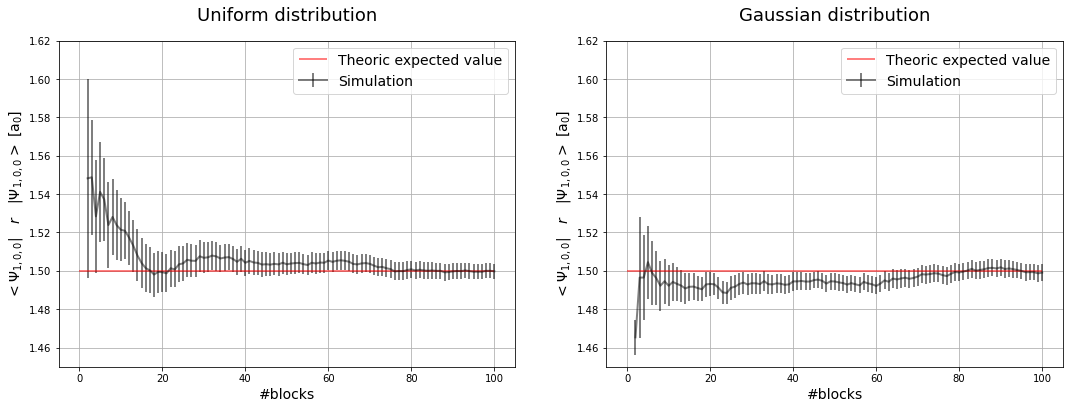

In [27]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title("Uniform distribution",fontsize=18,pad=20)
plt.errorbar(x, data0.T[0], yerr=data0.T[1], color='black', alpha=0.5, label='Simulation', linewidth=2)
plt.hlines(1.5,0,Nblocks, color='red', linestyle='-', label="Theoric expected value", linewidth=2, alpha=0.5)
plt.ylabel(r'$<\Psi_{1,0,0}|\quad r \quad|\Psi_{1,0,0}> \,\, [\mathrm{a_0}]$',fontsize=14)
plt.xlabel("#blocks",fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.ylim(1.45,1.62)

plt.subplot(1,2,2)
plt.title("Gaussian distribution",fontsize=18,pad=20)
plt.errorbar(x, data1.T[0], yerr=data1.T[1], color='black', alpha=0.5, label='Simulation', linewidth=2)
plt.hlines(1.5,0,Nblocks, color='red', linestyle='-', label="Theoric expected value", linewidth=2, alpha=0.5)
plt.ylabel(r'$<\Psi_{1,0,0}|\quad r \quad|\Psi_{1,0,0}> \,\, [\mathrm{a_0}]$',fontsize=14)
plt.xlabel("#blocks",fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.ylim(1.45,1.62)
plt.show()

Nel grafico a sinistra viene utilizzata come probabilità di transizione una distribuzione uniforme con passo di larghezza $1.22\,a_0$, mentre nel grafico a destra viene scelta come probabilità di transizione una distribuzione gaussiana con deviazione standard $\sigma=0.76\,a_0$.
Come possiamo osservare i risultati ottenuti con le due diverse distribuzioni sono tra loro equivalenti e compatibili con la previsione teorica.
Questo risultato può essere giustificato dal fatto che entrambe le $T(\vec{x}|\vec{y})$ consentono all'accettazione di semplificarsi nella forma che abbiamo precedentemente ricavato e trovare dunque per entrambe una $A(\vec{x}|\vec{y})$ indipendente dalla probabilità di transizione.
Ciò non è scontato, poichè la scelta di $T(\vec{x}|\vec{y})$, in generale, influisce in maniera determinante sulla convergenza dell'algoritmo e sull'efficienza dello stesso.

**B) Orbitale 2p**:

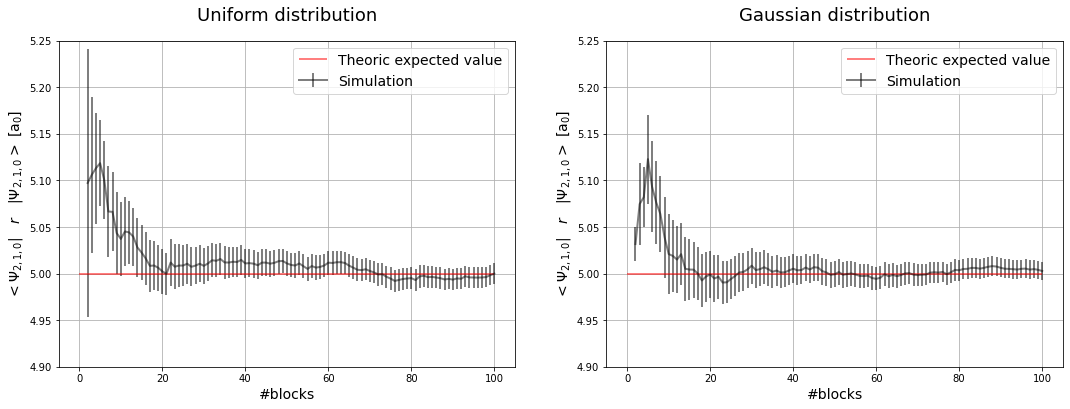

In [28]:
data2=np.loadtxt("2p_uniform.dat")
data3=np.loadtxt("2p_gaussian.dat")

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title("Uniform distribution",fontsize=18,pad=20)
plt.errorbar(x, data2.T[0], yerr=data2.T[1], color='black', alpha=0.5, label='Simulation', linewidth=2)
plt.hlines(5,0,Nblocks, color='red', linestyle='-', label="Theoric expected value", linewidth=2, alpha=0.5)
plt.ylabel(r'$<\Psi_{2,1,0}|\quad r \quad|\Psi_{2,1,0}> \,\, [\mathrm{a_0}]$',fontsize=14)
plt.xlabel("#blocks",fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.ylim(4.9,5.25)

plt.subplot(1,2,2)
plt.title("Gaussian distribution",fontsize=18,pad=20)
plt.errorbar(x, data3.T[0], yerr=data3.T[1], color='black', alpha=0.5, label='Simulation', linewidth=2)
plt.hlines(5,0,Nblocks, color='red', linestyle='-', label="Theoric expected value", linewidth=2, alpha=0.5)
plt.ylabel(r'$<\Psi_{2,1,0}|\quad r \quad|\Psi_{2,1,0}> \,\, [\mathrm{a_0}]$',fontsize=14)
plt.xlabel("#blocks",fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.ylim(4.9,5.25)
plt.show()

Per quanto riguarda il valore medio di $r$ con campionamento dell'orbitale 2p, viene utilizzata una probabilità di transizione uniforme con passo di larghezza $2.95\,a_0$ nel grafico a sinistra, mentre nel grafico a destra viene scelta come $T(\vec{x}|\vec{y})$ una distribuzione gaussiana con deviazione standard $\sigma=1.89\,a_0$.
Come possiamo osservare, anche in questo caso, i risultati ottenuti con le due diverse distribuzioni sono tra loro equivalenti e compatibili con la previsione teorica. Valgono dunque le stesse considerazioni fatte in precedenza.